# Project McNulty - Weeks 04, 05, and 06

# _Classifying LandSat Images_, by Steven Bierer

## Data Assessment
(Jupyter Notebook 1 of 3)

### Scope of project:

The objective of this project was to train and test a classification model on a data set of our choice.  I chose to analyze LandSat imaging data with purely quantitive (spatial and spectral) features representing terrain types in an agricultural region.

The primary tools used were the Python libraries ```pandas```, ```numpy```, ```matplotlib```, and ```sklearn```. All data were obtained from [the UCL Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Landsat+Satellite%29).

#### -------- Section 1:  Load the image data and save as a dataframe ------------------------------------------

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%config InlineBackend.figure_format = 'png'  # format for Keynote
%matplotlib inline

import seaborn as sns

In [3]:
# Load the pre-defined training and test data sets #
# I'll evaluate below if the train/test separation is reasonable.
col_names = list(range(1,36+1))
col_names.append('Labels')

df_trainraw = pd.read_csv('data/sat.trn', sep=' ', header=None, names = col_names)
df_testraw = pd.read_csv('data/sat.tst', sep=' ', header=None, names = col_names)

In [4]:
# Split into labels and features #
# Column 0 = spectral+spatial average, Columns 1-36 = 3x3 grid of spectral magnitudes.
y_trainraw = df_trainraw['Labels']
X_trainraw = df_trainraw.drop(columns = ['Labels'])
mean_val = X_trainraw.mean(axis=1)
X_trainraw.insert(0, 0, None)
X_trainraw.iloc[:,0] = mean_val

y_testraw = df_testraw['Labels']
X_testraw = df_testraw.drop(columns = ['Labels'])
mean_val = X_testraw.mean(axis=1)
X_testraw.insert(0, 0, None)
X_testraw.iloc[:,0] = mean_val

y_trainraw[y_trainraw==7] = 6  # original class #6 has no objects, so shift #7 down
y_testraw[y_testraw==7] = 6

terrain_labels = {1:'red soil', 2:'cotton crop', 3:'grey soil', 4:'damp soil',
                 5:'vegetation', 6:'very damp soil'}

#### -------- Section 2:  Examine properties of the training data set  ------------------------------------------

In [5]:
# If starting here, load in the data saved previously #
# Elements are [X_trainraw, y_trainraw, X_testraw, y_testraw, terrain_labels].
import pickle

with open('data/dataframes_raw_20181023.pkl', 'rb') as picklefile: 
    raw_data = pickle.load(picklefile)

X_trainraw = raw_data[0]; y_trainraw = raw_data[1]
X_testraw = raw_data[2]; y_testraw = raw_data[3]
terrain_labels = raw_data[4]

In [6]:
# Import utility functions in ClassAnalysis (with option to reload when necessary) #
import ClassAnalysis
import importlib
importlib.reload(ClassAnalysis)
from ClassAnalysis import row2grid

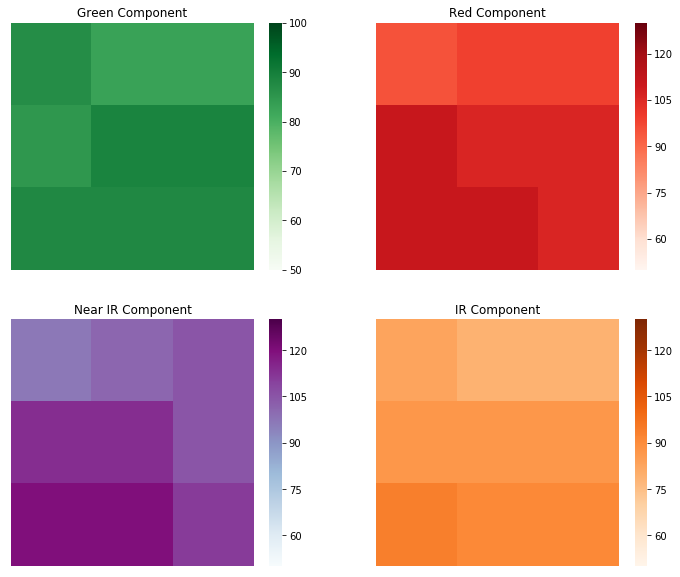

In [7]:
# Call a utility function to plot all spectral components of one 3x3 grid #
# This represents one row of data, columns 1-36 (skipping column 0 = average).
GRIDROW = 300
gridfig = row2grid(X_trainraw.iloc[GRIDROW,:])
gridfig.savefig('supporting_files/SpectralGrid.png',dpi=300)

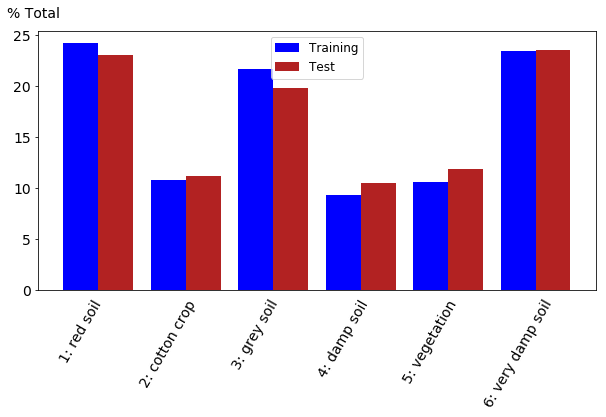

In [15]:
# Look at the general distribution of data features and labeled classes #
# It looks like the class distributions are about the same for the test and training
# sets, as predetermined in the UC Irvine database. So we'll use the sets as is.
# I also note that the distribution across classes appears moderately unbalanced.
labeltrain_counts = y_trainraw.value_counts()
labeltrain_pct = 100 * labeltrain_counts / labeltrain_counts.sum()
labeltest_counts = y_testraw.value_counts()
labeltest_pct = 100 * labeltest_counts / labeltest_counts.sum()

bar_labels = [(str(x) +': ' + terrain_labels[x]) for x in labeltrain_counts.index]
plt.bar(labeltrain_counts.index-0.2, labeltrain_pct.values,
        color = 'b', align='center', width=0.4)
plt.bar(labeltest_counts.index+0.2, labeltest_pct.values,
        color = np.array([178,34,34])/255, align='center', width=0.4)

ax = plt.gca(); fig = plt.gcf()
ax.set_xticks(labeltrain_counts.index - 0.2)
ax.set_xticklabels(bar_labels, rotation=60, fontsize=14)

ax.set_ylabel('% Total', fontsize=14, rotation = 0, ha='right')
ax.yaxis.set_label_coords(0.04,1.04)
ax.set_yticklabels(list(range(0,26,5)), fontsize=14)
plt.tick_params(axis='x',bottom=False)

fig.set_figwidth(10); fig.set_figheight(6)
fig.subplots_adjust(bottom=0.28)
fig.savefig('supporting_files/ClassDistr.svg',dpi=300)

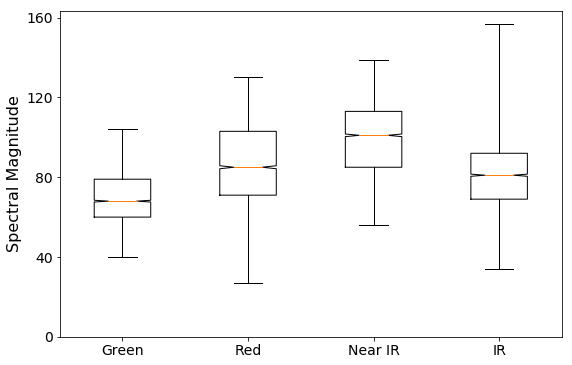

In [17]:
# Look at the magnitudes of all four spectral bands distributed across grid locations #
# They are overlapping and reasonably centered with each other (within about 30 units).
# Scaling won't be necessary (but will happen later anyway w/ PC analysis).

# sa_idx = list(range(1,34,4))   # in this version, average across all pixels in each grid
# sb_idx = list(range(2,37,4))
# sc_idx = list(range(3,37,4))
# sd_idx = list(range(4,37,4))
# sa_mean = X_trainraw.iloc[:,sa_idx].mean(axis=1)
# sb_mean = X_trainraw.iloc[:,sb_idx].mean(axis=1)
# sc_mean = X_trainraw.iloc[:,sc_idx].mean(axis=1)
# sd_mean = X_trainraw.iloc[:,sd_idx].mean(axis=1)

sa_idx = 17                    # in this version, just use the center pixel
sb_idx = 18
sc_idx = 19
sd_idx = 20
sa_mean = X_trainraw.iloc[:,sa_idx]
sb_mean = X_trainraw.iloc[:,sb_idx]
sc_mean = X_trainraw.iloc[:,sc_idx]
sd_mean = X_trainraw.iloc[:,sd_idx]

plt.boxplot([sa_mean, sb_mean, sc_mean, sd_mean], notch=True, whis=10);
plt.xticks(np.arange(1,5), ['Green','Red','Near IR','IR'], fontsize=14);
plt.yticks(np.arange(0,161,40), fontsize=14)
plt.ylabel('Spectral Magnitude', fontsize=16)

ax = plt.gca(); fig = plt.gcf()
fig.set_figwidth(9); fig.set_figheight(6)
fig.savefig('supporting_files/SpectralDistr.png', dpi=300)

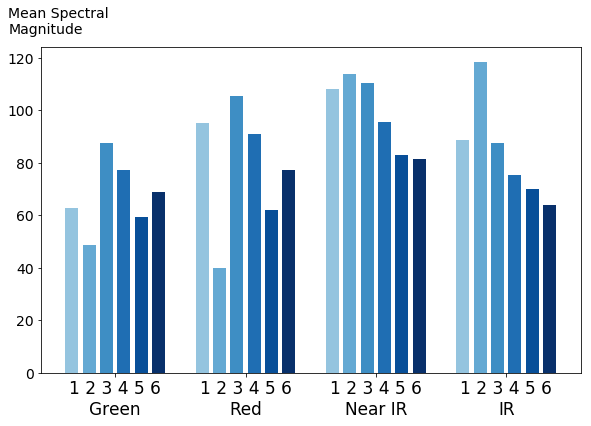

In [22]:
# Display average spectral components of each of the 6 terrain types #
# This gives an idea of how much each channel differs from others, in terms of spectral content.
# So, the classifier essentially has to train on noisy version of these "spectral signatures".
df_temp = pd.DataFrame({'a':sa_mean,'b':sb_mean,'c':sc_mean,'d':sd_mean,'Labels':y_trainraw})
df_classavg = df_temp.groupby('Labels').mean()

colorvec = cm.Blues(np.linspace(.4,1,6))
bins = np.arange(-1,1.1,.4) + 0
plt.bar(bins, df_classavg['a'], .3, align='center', color = colorvec);
bins = np.arange(-1,1.1,.4) + 3
plt.bar(bins, df_classavg['b'], .3, align='center', color = colorvec);
bins = np.arange(-1,1.1,.4) + 6
plt.bar(bins, df_classavg['c'], .3, align='center', color = colorvec);
bins = np.arange(-1,1.1,.4) + 9
plt.bar(bins, df_classavg['d'], .3, align='center', color = colorvec);

plt.xticks([0,3,6,9], ['1 2 3 4 5 6\nGreen','1 2 3 4 5 6\nRed',
                       '1 2 3 4 5 6\nNear IR','1 2 3 4 5 6\nIR'],
                        fontsize=17);
plt.yticks(fontsize=14)

ax = plt.gca(); fig = plt.gcf()
ax.set_ylabel('Mean Spectral\nMagnitude', fontsize=14, rotation = 0, ha='left')
ax.yaxis.set_label_coords(-0.06,1.03)

fig.set_figwidth(10); fig.set_figheight(6)
fig.subplots_adjust(left=0.15)
fig.savefig('supporting_files/ClassSpectra.svg', dpi=300)

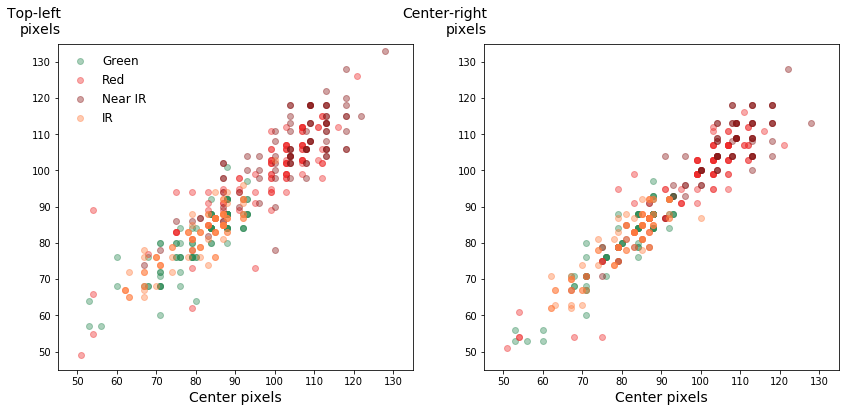

In [26]:
# Now at correlations between specific pixel locations across all of the 9x9 grids #
# As expected, there are heavy correlations.
P1 = np.arange(17,21)   # center pixel
P2 = np.arange(1,5)     # top-left pixel (for example)
P3 = np.arange(21,25)   # center-right pixel (for example)

NPTS = 100              # only plot a subset of data points
colorvec = [np.array([46,139,87])/255, np.array([238,44,44])/255,
            np.array([139,26,26])/255, np.array([255,125,64])/255]

fig, axset = plt.subplots(1, 2, figsize=[10,4])

for i, pts in enumerate(zip(P1,P2,P3)):
    s1_pts = X_trainraw.iloc[:,pts[0]].values.ravel()
    s2_pts = X_trainraw.iloc[:,pts[1]].values.ravel()
    s3_pts = X_trainraw.iloc[:,pts[2]].values.ravel()
    
    axset[0].scatter(s1_pts[:NPTS], s2_pts[:NPTS], c=colorvec[i], alpha=.4);
    axset[1].scatter(s1_pts[:NPTS], s3_pts[:NPTS], c=colorvec[i], alpha=.4);

ylim1, ylim2 = axset[0].get_ylim()

axset[0].set_xlim([45,135]); axset[1].set_xlim([45,135])
axset[0].set_ylim([45,135]); axset[1].set_ylim([45,135])
axset[0].set_xticks(np.arange(50,131,10))
axset[1].set_xticks(np.arange(50,131,10))
axset[0].set_yticks(np.arange(50,131,10))
axset[1].set_yticks(np.arange(50,131,10))

axset[0].set_xlabel('Center pixels', fontsize=14);
axset[1].set_xlabel('Center pixels', fontsize=14);
axset[0].set_ylabel('Top-left\npixels', fontsize=14, rotation=0, ha='right');
axset[1].set_ylabel('Center-right\npixels', fontsize=14, rotation=0, ha='right');
axset[0].yaxis.set_label_coords(0.01,1.02)
axset[1].yaxis.set_label_coords(0.01,1.02)

# axset[0].set_title('Spectral magnitudes at two grid locations')
# axset[1].set_title('Spectral magnitudes at two grid locations')
axset[0].legend(['Green','Red','Near IR','IR'], fontsize=12, frameon=False);

fig = plt.gcf()
fig.set_figwidth(14); fig.set_figheight(6)
fig.savefig('supporting_files/PixelCorrelation.png', dpi=500)